In [15]:
# Load the data 

import pandas as pd

data_file = 'Debernardi et al 2020 data.csv'

data = pd.read_csv(data_file)



In [16]:
# Convert diagnosis to binary and drop the original column
data['diagnosis_binary'] = data['diagnosis'].apply(lambda x: 1 if x == 1 else 0)
data.drop(columns=['diagnosis'], inplace=True)


In [17]:
# Display basic information about the dataset
print("Data Types and Non-Null Counts:")
print(data.info())

print("\nSummary Statistics:")
print(data.describe(include='all'))

print("\nMissing Values Per Column:")
print(data.isnull().sum())


Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64

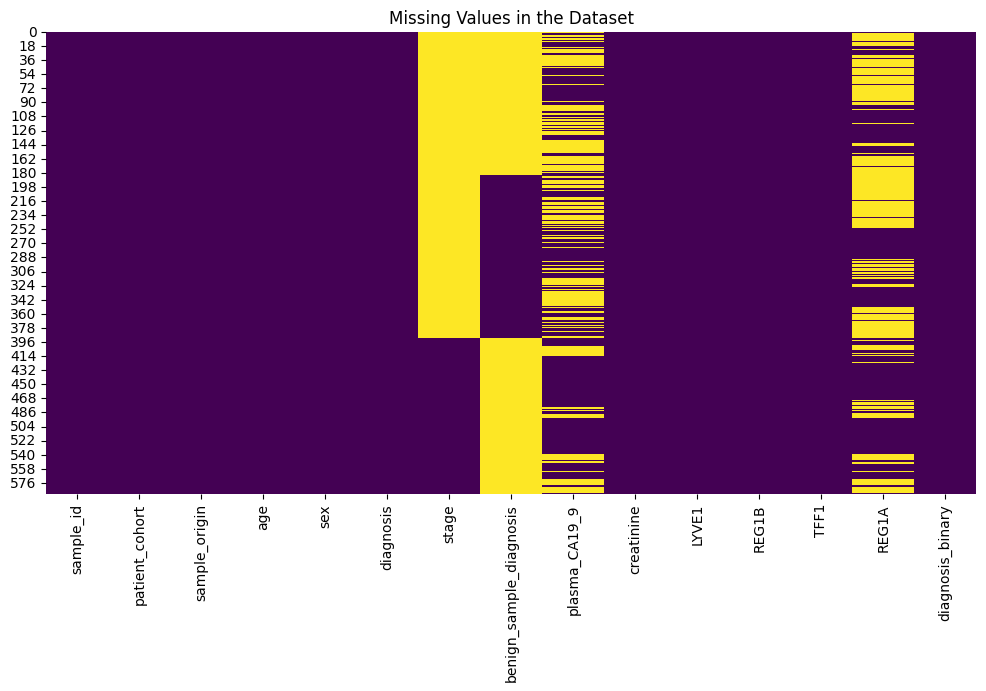

In [18]:
# Visualising missing values


import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the missing values in the dataset
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in the Dataset')
plt.show()


In [19]:
# Dropping columns 

import numpy as np

# Drop columns with a significant amount of missing data and non-relevant columns
columns_to_drop = ['stage', 'sample_id', 'sample_origin', 'benign_sample_diagnosis', 'REG1A', 'plasma_CA19_9']
columns_to_drop = [col for col in columns_to_drop if col in data.columns]
data.drop(columns=columns_to_drop, inplace=True)

In [20]:
# Encode categorical variables


from sklearn.preprocessing import LabelEncoder

label_encoders = {}
categorical_columns = ['sex', 'patient_cohort']
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Display the first few rows of the updated dataframe to confirm changes
print(data.head())


   patient_cohort  age  sex  diagnosis  creatinine     LYVE1      REG1B  \
0               0   33    0          1     1.83222  0.893219   52.94884   
1               0   81    0          1     0.97266  2.037585   94.46703   
2               1   51    1          1     0.78039  0.145589  102.36600   
3               1   61    1          1     0.70122  0.002805   60.57900   
4               1   62    1          1     0.21489  0.000860   65.54000   

         TFF1  diagnosis_binary  
0  654.282174                 1  
1  209.488250                 1  
2  461.141000                 1  
3  142.950000                 1  
4   41.088000                 1  


In [21]:
#Notmalize numerical features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = ['age', 'creatinine', 'LYVE1', 'REG1B', 'TFF1',]
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Display the first few rows of the updated dataframe to confirm changes
print(data.head())


   patient_cohort       age  sex  diagnosis  creatinine     LYVE1     REG1B  \
0               0 -1.991056    0          1    1.529927 -0.631661 -0.299975   
1               0  1.673512    0          1    0.183680 -0.298597 -0.088256   
2               1 -0.616843    1          1   -0.117454 -0.849256 -0.047976   
3               1  0.146609    1          1   -0.241451 -0.890812 -0.261065   
4               1  0.222954    1          1   -1.003143 -0.891378 -0.235767   

       TFF1  diagnosis_binary  
0  0.055876                 1  
1 -0.384680                 1  
2 -0.135425                 1  
3 -0.450584                 1  
4 -0.551475                 1  


In [22]:
# Identify target value

target = 'diagnosis_binary'  # Use the binary target variable
X = data.drop(columns=[target])
y = data[target]



Class Distribution in Target Variable:
diagnosis_binary
0    407
1    183
Name: count, dtype: int64


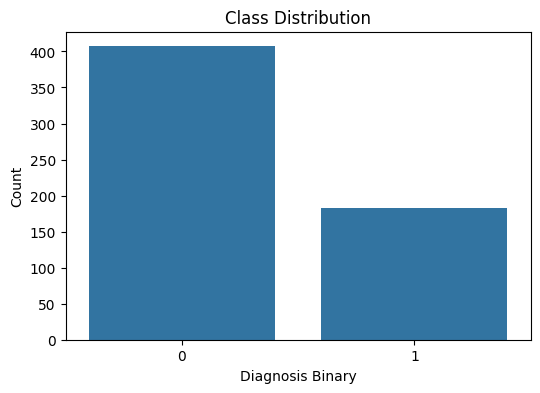

In [23]:
# Check for Class Imbalance

print("Class Distribution in Target Variable:")
print(y.value_counts())

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Diagnosis Binary')
plt.ylabel('Count')
plt.show()


In [24]:
# Smote over sampling (test the models with and without it)

from imblearn.over_sampling import SMOTE



X = data.drop(columns=['diagnosis_binary'])
y = data['diagnosis_binary']

# Applying SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Checking the distribution after SMOTE
print(f'Class distribution before SMOTE: {y.value_counts()}')
print(f'Class distribution after SMOTE: {y_smote.value_counts()}')

# Update the dataset with SMOTE results
data_smote = pd.concat([X_smote, y_smote], axis=1)


Class distribution before SMOTE: diagnosis_binary
0    407
1    183
Name: count, dtype: int64
Class distribution after SMOTE: diagnosis_binary
1    407
0    407
Name: count, dtype: int64


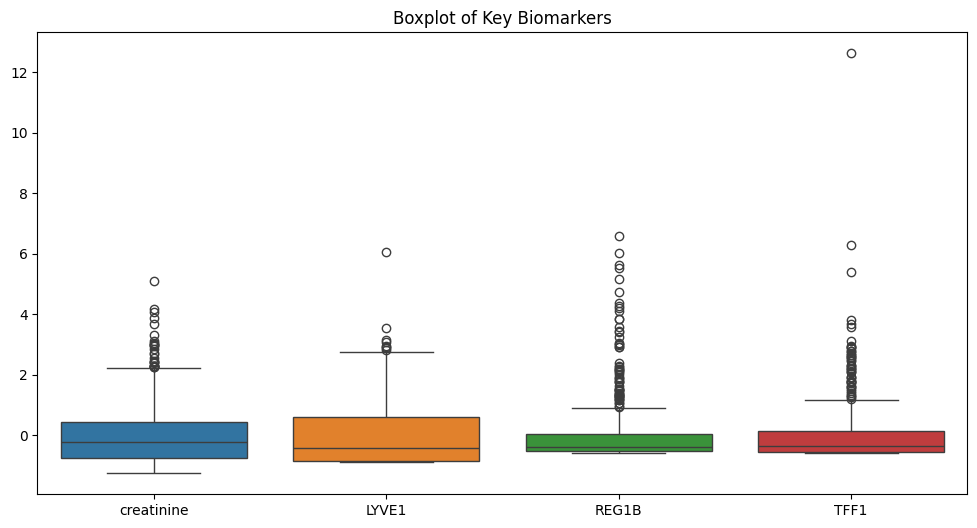

In [25]:
# Outlier Identifiction

import seaborn as sns
import matplotlib.pyplot as plt


# Plotting to visually inspect 
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['creatinine', 'LYVE1', 'REG1B', 'TFF1']])
plt.title('Boxplot of Key Biomarkers')
plt.show()





In [26]:
# Identify outliers using Z-score
from scipy import stats
import numpy as np

def identify_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
    outliers = (z_scores > threshold).any(axis=1)
    return outliers

outliers = identify_outliers_zscore(data[['creatinine', 'LYVE1', 'REG1B', 'TFF1']])
print(f"Number of outliers identified: {outliers.sum()}")

# Remove outliers
data_clean = data[~outliers]
print(f"Data shape after removing outliers: {data_clean.shape}")


Number of outliers identified: 29
Data shape after removing outliers: (561, 9)


In [27]:
# Resampling outliers with bootstrapping
from sklearn.utils import resample

def bootstrap_summary(data, n_iterations=1000):
    samples = []
    for _ in range(n_iterations):
        sample = resample(data, replace=True, n_samples=len(data))
        samples.append(sample.describe())
    summary = pd.concat(samples, axis=0).groupby(level=0).mean()
    return summary

# Applying bootstrapping on data with outliers removed
bootstrap_results = bootstrap_summary(data_clean[['creatinine', 'LYVE1', 'REG1B', 'TFF1']])
print(bootstrap_results)


       creatinine       LYVE1       REG1B        TFF1
25%     -0.771064   -0.849205   -0.519546   -0.551659
50%     -0.259127   -0.450392   -0.407062   -0.360909
75%      0.359152    0.469860   -0.025170    0.059157
count  561.000000  561.000000  561.000000  561.000000
max      2.916738    2.906148    2.925070    2.921618
mean    -0.084561   -0.087355   -0.143250   -0.122770
min     -1.244387   -0.891589   -0.569868   -0.592165
std      0.873388    0.889438    0.609513    0.649200


In [ ]:
# Normalize numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = ['age', 'creatinine', 'LYVE1', 'REG1B', 'TFF1']
data_clean[numerical_columns] = scaler.fit_transform(data_clean[numerical_columns])

# Display the first few rows of the updated dataframe to confirm changes
print(data_clean.head())


In [28]:
# Split to train and test data

from sklearn.model_selection import train_test_split

X = data_smote.drop(columns=['diagnosis_binary'])
y = data_smote['diagnosis_binary']

# Split the cleaned data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display the shape of the resulting datasets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (651, 8)
Testing set shape: (163, 8)


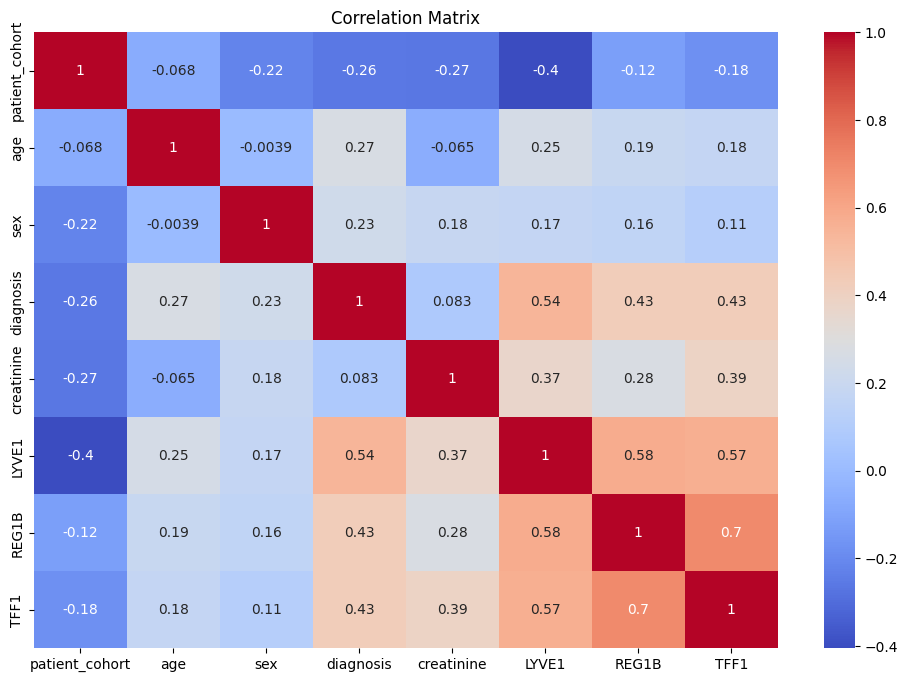

In [29]:
# Correlation matrix

# Exclude non-numeric columns
numeric_X_train = X_train.select_dtypes(include=[np.number])

# Check for correlations
correlation_matrix = numeric_X_train.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
